Single spillover (non-recurrent) with finite population, death, and SIS dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
#class representing one simulation.
#an instance of this class contains enough information to plot some pictures.
#the return value for sim_class and for recurrent_sim_class is an instance of this class. 

class Sim:
    def __init__(self, outcome, times, betas, gammas, deltas, I, S, D):
        
        #0 if extinction, 1 if outbreak, None otherwise. 
        #(note sim_class will always return 0 or 1 here, but recurrent_sim_class may return None)
        self.outcome = outcome 
        
        #the number of events in the simulation
        self.length = len(times) # note this is = len(self.betas) = len(self.gammas)= len(self.N)
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        self.deltas = deltas
        self.S = S
        self.D = D

In [26]:
#############################################################
# version of sim which 
#    1. is implemented in "time order" instead of "generation order"
#        (this makes it slower to run, but it's needed in order to make accurate plots)
#    2. returns an element of the class Sim.
#    3. distinguishes between recovery (gamma) and death (deltas).
#    4. runs on a finite population (SIS model with death).
#############################################################
#
# S_0 is initial susceptible population
# t_thresh is optional input. how long to run the simulation before stopping.
#
#############################################################

def sim_finite(S_0, beta_0, gamma_0, delta_0, mu_1=0, mu_2=0, mu_3=0, t_thresh = 1000):

    t=0
        
    #stuff to fill and return as part of Sim object.
    all_times = np.array([t])
    all_betas = np.array([beta_0])
    all_gammas = np.array([gamma_0])
    all_deltas = np.array([delta_0])
    all_I = np.array([1])
    all_S = np.array([S_0])
    all_D = np.array([0]) 
    
    #initialize counters
    S = S_0; I = 1; D = 0
        
    #initialize variables to keep track of sums of beta, gamma, and delta over all currently infected people    
    beta_sum = beta_0; gamma_sum = gamma_0; delta_sum = delta_0
        
    #initialize matrix of active cases. each case is a row of length 4.
    # each row looks like [beta, gamma, delta, time of infection] of that person. 
    infecteds=np.array([[beta_0, gamma_0, delta_0, t]])
    
    while True:
        
        total_pop = S + I + D #total population (this is what's usually called N.)
        
        #grab array of all betas and array of all gammas
        betas = infecteds[:,0]; gammas = infecteds[:,1]; deltas = infecteds[:,2]
        
        #adjust betas to actual transmission rates, which depend on proportion of population that is susceptible
        trans_rates = betas*S/total_pop
        
        trans_rates_sum = np.sum(trans_rates) #sum all trans rates
        
        #compute interevent time (for the whole population)
        
        #rate of events is sum of transmission rate and gamma and delta over all infected people
        overall_rate = trans_rates_sum + gamma_sum + delta_sum
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt
        
        #return if next event is after t_thresh
        if t > t_thresh:
            return Sim(None, all_times, all_betas, all_gammas, all_deltas, all_I, all_S, all_D)
        
        #figure out who the event happened to
        i = np.random.choice(I, p=(trans_rates+gammas+deltas)/overall_rate) #index of that person
        
        #grab their specific transmission rate and beta and gamma and delta
        beta = betas[i]; gamma = gammas[i]; delta = deltas[i]
        
        #compute transmission rate
        trans_rate = beta*S/total_pop
        
        #figure out what they did, transmit, recover, or die
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = trans_rate / (trans_rate + gamma + delta) #probability of transmission
        prob_recovery = gamma / (trans_rate + gamma + delta)
        
        if (ev < prob_trans): #transmission

            #pick beta, gamma, and delta for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2 or mu_3
            #don't allow negative beta.
            #don't allow gamma to be negative. 
            #don't allow delta to be less than a small value, the natural death rate.
            mut1 = np.random.normal(loc=0.0, scale=mu_1)
            new_beta = max(0, beta + mut1)
            mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_gamma = max(0, gamma + mut2)
            mut3 = np.random.normal(loc=0.0, scale=mu_3)              
            nat_death = 0.00002366575 #taken from CDC: 
                #https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
            new_delta = max(nat_death, delta + mut3)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, new_delta, t]], axis=0)
            
            #update the sums of beta, gamma and delta
            beta_sum += new_beta; gamma_sum += new_gamma; delta_sum += new_delta
            
            #update counters
            I += 1; S -= 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, new_beta)
            all_gammas = np.append(all_gammas, new_gamma)
            all_deltas = np.append(all_deltas, new_delta)
            all_I = np.append(all_I, I)
            all_S = np.append(all_S, S)
            all_D = np.append(all_D, D) 
    
        elif (ev < prob_trans + prob_recovery): #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta, gamma and delta
            beta_sum += beta; gamma_sum -= gamma; delta_sum -= delta
            
            #update counters
            I -= 1; S += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_deltas = np.append(all_deltas, None)
            all_I = np.append(all_I, I)
            all_S = np.append(all_S, S)
            all_D = np.append(all_D, D) 
            
            #check for extinction
            if I == 0:
                return Sim(0, all_times, all_betas, all_gammas, all_deltas, all_I, all_S, all_D)
            
        else: #death
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
            
            #update the sums of beta, gamma and delta
            beta_sum += beta; gamma_sum -= gamma; delta_sum -= delta
            
            #update counters
            I -= 1; D += 1
            
            #update return arrays
            all_times = np.append(all_times, t)
            all_betas = np.append(all_betas, None)
            all_gammas = np.append(all_gammas, None)
            all_deltas = np.append(all_deltas, None)
            all_I = np.append(all_I, I)
            all_S = np.append(all_S, S)
            all_D = np.append(all_D, D) 
            
            #check for extinction
            if I == 0:
                return Sim(0, all_times, all_betas, all_gammas, all_deltas, all_I, all_S, all_D)
            

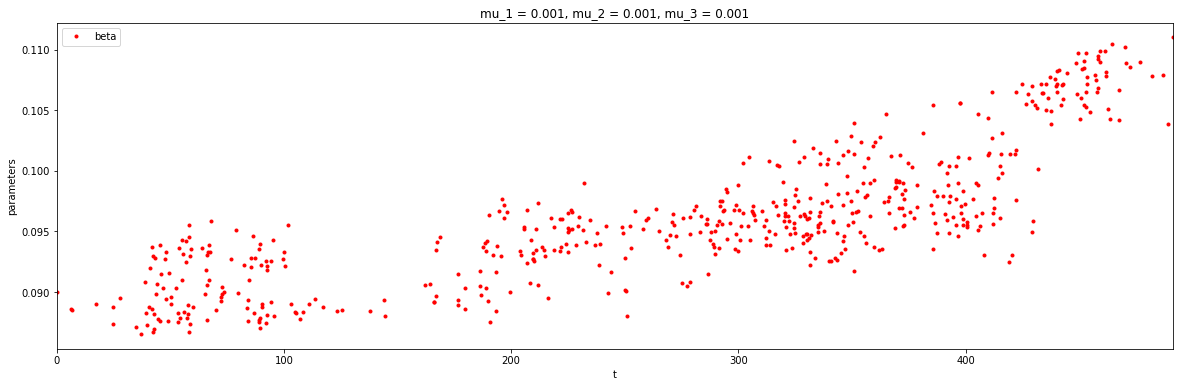

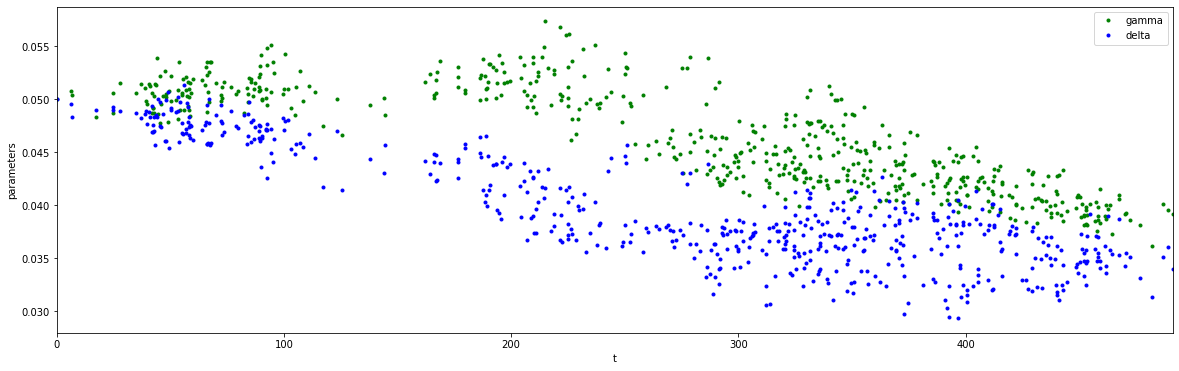

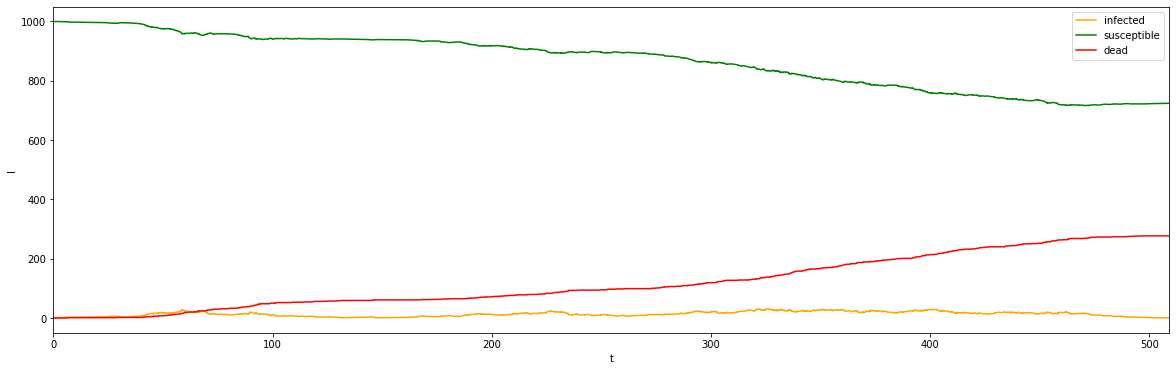

In [27]:
#parameters
S_0 = 1000
beta_0 = 0.09
gamma_0 = 0.05
delta_0 = 0.05
mu_1 = 0.001
mu_2 = 0.001
mu_3 = 0.001

s = None

while True:
    s = sim_finite(S_0, beta_0, gamma_0, delta_0, mu_1, mu_2, mu_3, t_thresh = 1000)
    if s.times[-1] > 500: break #get a simulation where the disease spreads for at least this many days
        
times = s.times; betas = s.betas; gammas = s.gammas; deltas = s.deltas; I = s.I; S = s.S; D = s.D

#plot betas over time
plt.figure(figsize=(20,6))
plt.plot(times, betas, ".r", label='beta')
plt.title('mu_1 = {}, mu_2 = {}, mu_3 = {}'.format(mu_1, mu_2, mu_3))
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot gammas and deltas over time
plt.figure(figsize=(20,6))
plt.plot(times, gammas, ".g", label='gamma')
plt.plot(times, deltas, ".b", label='delta')
plt.xlabel("t"); plt.ylabel("parameters")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()

#plot I over time
plt.figure(figsize=(20,6))
plt.plot(times, I, 'orange', label='infected')
plt.plot(times, S, 'green', label='susceptible')
plt.plot(times, D, 'red', label='dead')
plt.xlabel("t"); plt.ylabel("I")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(); plt.show()